In [1]:
# imports for Qiskit

from qiskit.tools.monitor import job_monitor
from qiskit import BasicAer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.compiler import transpile
import numpy as np

from qiskit.tools.visualization import plot_histogram

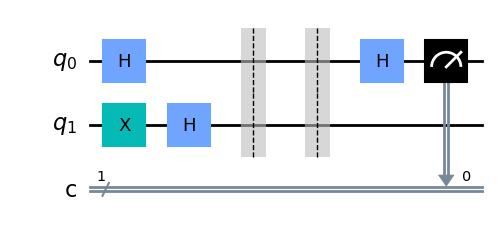

In [2]:
dj = QuantumCircuit(2,1)

dj.h(0)

dj.x(1)

dj.h(1)

dj.barrier()

# These lines define the blackbox or Oracle
# you should uncomment one of these lines to see how the oracle works

# This line is for a constant function F --> 0
#dj.i(0)

# This line is for a constant function F --> 1
#dj.x(0) 

# This line is for a balanced function 
#50% of the time, F --> 0 and the other 50% of the time, F --> 1
#dj.cx(0,1)

dj.barrier()

dj.h(0)

dj.measure(0,0)

dj.draw(output="mpl")

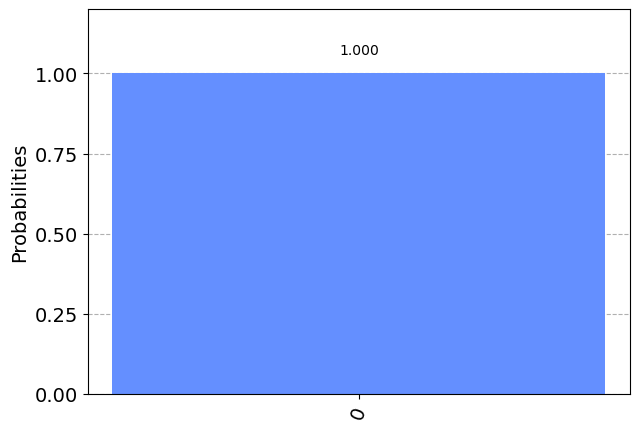

In [3]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 2048
job = execute(dj, backend=backend, shots=shots)
results = job.result() 
answer = results.get_counts()

plot_histogram(answer)

In [4]:
n = 1 # the length of the first register for querying the oracle 

In [5]:
# Choose a type of oracle at random. With probability half it is constant, 
# and with the same probability it is balanced
oracleType, oracleReturn = np.random.randint(2), np.random.randint(2)

# you can comment out the print to hide what kind of oracle is used
if oracleType == 0:
    print("The oracle returns a constant value ", oracleReturn)
else:
    print("The oracle returns a balanced function")
    a = np.random.randint(1,2**n) # this is a hidden parameter for balanced oracle. 

## Creating the circuit

# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(n+1) #all qubits are initialized to zero for recording the measurement on the first register
cr = ClassicalRegister(n)

circuitName = "DeutschJozsa"
djCircuit = QuantumCircuit(qr,cr)


## creating the query 


# Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
for i in range(n):
    djCircuit.h(qr[i])

# Flip the second register and apply the Hadamard gate.
djCircuit.x(qr[n])
djCircuit.h(qr[n])




## Applying either a balanced or constant oracle at random

# Apply barrier to mark the beginning of the oracle
djCircuit.barrier()

if oracleType == 0:#If the oracleType is "0", the oracle returns oracleReturn for all input. 
    if oracleReturn == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.id(qr[n])
else: # Otherwise, it returns the inner product of the input with a (non-zero bitstring) 
    for i in range(n):
        if (a & (1 << i)):
            djCircuit.cx(qr[i], qr[n])
        
# Apply barrier to mark the end of the oracle
djCircuit.barrier()


## Apply H gate to measure in the X-basis

# Apply Hadamard gates after querying the oracle
for i in range(n):
    djCircuit.h(qr[i])
    
# Measurement
for i in range(n):
    djCircuit.measure(qr[i], cr[i])

The oracle returns a balanced function


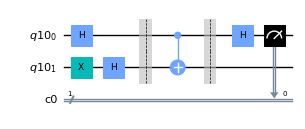

In [6]:
djCircuit.draw(output='mpl',scale=0.5)

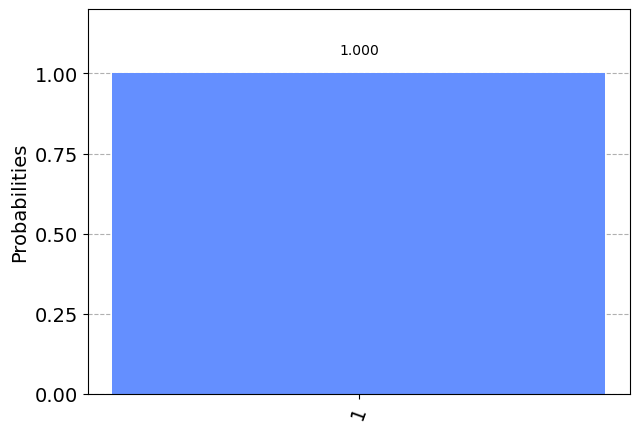

In [7]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 2048
job = execute(djCircuit, backend=backend, shots=shots)
results = job.result() 
answer = results.get_counts()

plot_histogram(answer)

### Deutsch-Jozsa Speedup

The Deutsch-Jozsa algorithm provides an exponential speedup compared to classical computers. The Deutsch-Jozsa algorithm determines whether the function $f$ is constant or balanced (with the promise that the function is one of the two). This was the first algorithm to prove quantum advantage since a classical computer requires $2^{n-1} + 1$ queries while a quantum computer only requires one quantum oracle (where n is the number of bits that the function acts on). The quantum oracle that I gave in the first part of the circuit was $|+\rangle \otimes n$ for n qubits and $|-\rangle$ for the last qubit. We can then apply the hidden oracle. Then we can apply $H \otimes n$ then measure the qubits. If the output is 1 then the state is balanced, and if the output is 0 then the state constant. Therefore we only need one quantum query to determine whether a function $f$ is constant or balanced.

